In [78]:
%matplotlib inline
import sys
sys.path.append("../functions")
from utils import * 
from analytical import * 
from main import predict
import matplotlib.pyplot as plt
from computer_vision import otsu
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Cluster The Data

In [2]:
X_train, Y_train, X_test = load_data()

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [03:10<00:00,  4.71it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:02<00:00, 24.69it/s]

Done!


In [3]:
train_clusters = cluster_training_data(X_train, Y_train)
test_clusters = cluster_test_data(X_test)

# Features

In [4]:
from skimage import exposure
import cv2

def basis_map(image):
    new_image = np.zeros((image.shape[0], image.shape[1], 8))
    mean = np.mean(image)
    std = np.std(image)
    bilateral = cv2.bilateralFilter(np.mean(image * 255, axis=2).astype("uint8"),2,75,75) / 255.0
    p2, p98 = np.percentile(image, (2, 98))
    img_rescale = np.mean(exposure.rescale_intensity(image, in_range=(p2, p98)), axis=2)
    equalize_hist = np.mean(exposure.equalize_adapthist(image, clip_limit=0.03), axis=2)
    for i in range(len(image)):
        for j in range(len(image)):
            new_image[i][j][0] = image[i][j][0]
            new_image[i][j][1] = image[i][j][1]
            new_image[i][j][2] = image[i][j][2]
            new_image[i][j][3] = (np.mean(image[i][j]) - mean) / std
            new_image[i][j][4] = bilateral[i][j]
            new_image[i][j][5] = img_rescale[i][j]
            new_image[i][j][6] = equalize_hist[i][j]
    for i in range(len(image)):
        for j in range(len(image)):
            lower_i = max(i - 1, 0)
            upper_i = min(i + 1, image.shape[0] - 1)
            lower_j = max(j - 1, 0)
            upper_j = min(j + 1, image.shape[1] - 1)
            new_image[i][j][7] = np.mean([np.linalg.norm(new_image[i][j] - new_image[neighbor_i][neighbor_j]) for neighbor_i in range(lower_i, upper_i + 1) for neighbor_j in range(lower_j, upper_j + 1)])
    return np.nan_to_num(new_image)

In [5]:
modality = "sparse"

In [6]:
basis_features = []
for i in range(len(train_clusters[modality]["x"])):
    print i * 100.0 / len(train_clusters[modality]["x"])
    basis_features.append(basis_map(train_clusters[modality]["x"][i]))

0.0


/usr/local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


0.18315018315
0.3663003663
0.549450549451
0.732600732601
0.915750915751
1.0989010989
1.28205128205
1.4652014652
1.64835164835
1.8315018315
2.01465201465
2.1978021978
2.38095238095
2.5641025641
2.74725274725
2.9304029304
3.11355311355
3.2967032967
3.47985347985
3.663003663
3.84615384615
4.0293040293
4.21245421245
4.3956043956
4.57875457875
4.7619047619
4.94505494505
5.12820512821
5.31135531136
5.49450549451
5.67765567766
5.86080586081
6.04395604396
6.22710622711
6.41025641026
6.59340659341
6.77655677656
6.95970695971
7.14285714286
7.32600732601
7.50915750916
7.69230769231
7.87545787546
8.05860805861
8.24175824176
8.42490842491
8.60805860806
8.79120879121
8.97435897436
9.15750915751
9.34065934066
9.52380952381
9.70695970696
9.89010989011
10.0732600733
10.2564102564
10.4395604396
10.6227106227
10.8058608059
10.989010989
11.1721611722
11.3553113553
11.5384615385
11.7216117216
11.9047619048
12.0879120879
12.2710622711
12.4542124542
12.6373626374
12.8205128205
13.0036630037
13.1868131868
13.

# SVM 

In [7]:
svm_features_seperate = np.nan_to_num([x.reshape((128*128, 8)) for x in basis_features])

In [8]:
svm_features = []
svm_labels = []
for i in range(len(svm_features_seperate)):
    svm_features.extend(svm_features_seperate[i])
    svm_labels.extend(train_clusters[modality]["y"][i].reshape((128*128)))

In [9]:
less_svm_features = []
less_svm_labels = []
for i in range(0, len(svm_features), 10000):
    less_svm_features.append(svm_features[i])
    less_svm_labels.append(svm_labels[i])

In [16]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(less_svm_features, np.array(less_svm_labels) > 0)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
from sklearn.svm import SVR
SVRegressor = SVR()
SVRegressor.fit(less_svm_features, np.array(less_svm_labels) > 0)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [101]:
from sklearn.neighbors import KNeighborsRegressor as KNR
KNRegressor = KNR(weights='distance')
KNRegressor.fit(less_svm_features, np.array(less_svm_labels) > 0)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [14]:
def svm_predict(image, clf):
    new_image = np.zeros((128, 128))
    for i in range(len(image)):
        for j in range(len(image[0])):
            new_image[i][j] = clf.predict(image[i][j].reshape(1, -1))
    return new_image

In [53]:
threshold_local?

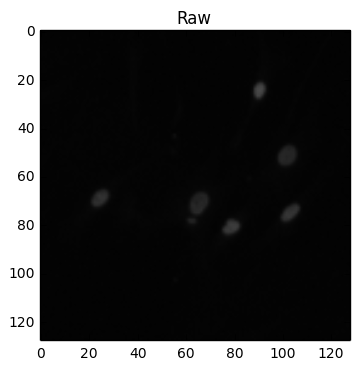

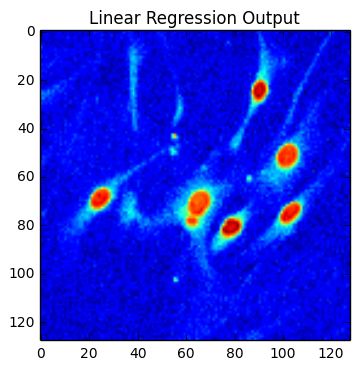

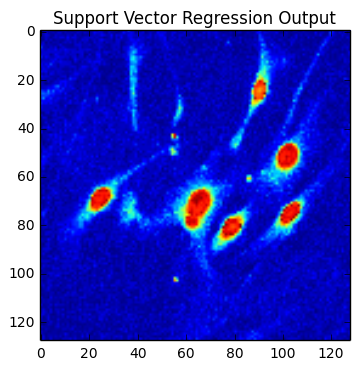

In [ ]:
f1s = []
for im in test_clusters[modality]:
    plt.imshow(im, cmap='jet')
    plt.title("Raw")
    plt.show()
    plt.imshow(svm_predict(basis_map(im), LR), cmap='jet')
    plt.title("Linear Regression Output")
    plt.show()
    plt.imshow(svm_predict(basis_map(im), SVRegressor), cmap='jet')
    plt.title("Support Vector Regression Output")
    plt.show()
    plt.imshow(svm_predict(basis_map(im), KNRegressor), cmap='jet')
    plt.title("KNN Regression Output")
    plt.show()

# UNet

In [89]:
from keras.models import Model, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


In [90]:
import tensorflow as tf

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [95]:
def get_unet_128():
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=[mean_iou])

    return model

model = get_unet_128()

earlystopper = EarlyStopping(patience=5, verbose=1, min_delta = .0001)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

ValueError: Input 0 is incompatible with layer conv2d_39: expected ndim=4, found ndim=3

In [96]:
results = model.fit(np.array(train_predictions), np.array(train_clusters["sparse"]["y"])[:len(train_predictions)], validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

ValueError: Error when checking input: expected input_2 to have 4 dimensions, but got array with shape (5, 128, 128)

In [1024]:
def predict(x_test):
    if is_sparse(x_test):
        predictions = (model.predict(basis_map(otsu(x_test)).reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))).reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    else:
        if is_black_white(X_test):
            predictions = (model.predict(basis_map(otsu(x_test)).reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))).reshape(IMG_HEIGHT, IMG_WIDTH, 1)
        else:
            if has_white_background(x_test):
                if (has_purple_foreground(x_test)):
                    predictions = (model.predict(basis_map(otsu(1 - x_test, lower_bound = .7)).reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))).reshape(IMG_HEIGHT, IMG_WIDTH, 1)
                else:
                    predictions = (model.predict(basis_map(otsu(1 - x_test)).reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))).reshape(IMG_HEIGHT, IMG_WIDTH, 1)
            else:
                predictions =(model.predict(basis_map(otsu(1 - x_test, lower_bound = .7)).reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))).reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    return np.squeeze(predictions) 

In [1025]:
def otsu_predict(x_test):
    if is_sparse(x_test):
        return otsu(x_test)
    else:
        if is_black_white(x_test):
            return otsu(x_test)
        else:
            if has_white_background(x_test):
                if (has_purple_foreground(x_test)):
                    return otsu(1 - x_test, lower_bound = .7)                
                else:
                    return otsu(1 - x_test)     
            else:
                return otsu(1 - x_test)                

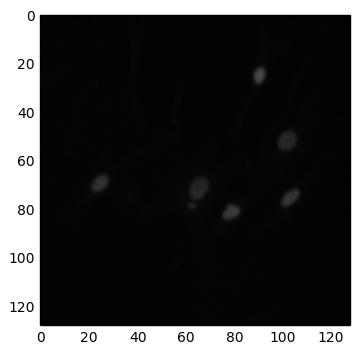

(128, 128, 3)


IndexError: too many indices for array

In [119]:
modality = "sparse"
f1s = []
for im in test_clusters[modality]:
    plt.imshow(im)
    plt.show()
    print im.shape
    predictions = predict(im)
    plt.imshow(predictions, cmap='jet')
    plt.show()
    plt.imshow(otsu(predictions))
    plt.show()
    plt.show()

In [485]:
# -*- coding: utf-8 -*-

"""
morphsnakes
===========

This is a Python implementation of the algorithms introduced in the paper

  Márquez-Neila, P., Baumela, L., Álvarez, L., "A morphological approach
  to curvature-based evolution of curves and surfaces". IEEE Transactions
  on Pattern Analysis and Machine Intelligence (PAMI), 2013.

This implementation is intended to be as brief, understandable and self-contained
as possible. It does not include any enhancement to make it fast or efficient.

Any practical implementation of this algorithm should work only over the
neighbor pixels of the 0.5-levelset, not over all the embedding function,
and perhaps should feature multi-threading or GPU capabilities.

The classes MorphGAC and MorphACWE provide most of the functionality of this
module. They implement the Morphological Geodesic Active Contours and the
Morphological Active Contours without Edges, respectively. See the
aforementioned paper for full details.

See test.py for examples of usage.
"""

__author__ = "P. Márquez Neila <p.mneila@upm.es>"

from itertools import cycle

import numpy as np
from scipy import ndimage
from scipy.ndimage import binary_dilation, binary_erosion, \
                        gaussian_filter, gaussian_gradient_magnitude

class fcycle(object):
    
    def __init__(self, iterable):
        """Call functions from the iterable each time it is called."""
        self.funcs = cycle(iterable)
    
    def __call__(self, *args, **kwargs):
        f = next(self.funcs)
        return f(*args, **kwargs)
    

# SI and IS operators for 2D and 3D.
_P2 = [np.eye(3), np.array([[0,1,0]]*3), np.flipud(np.eye(3)), np.rot90([[0,1,0]]*3)]
_P3 = [np.zeros((3,3,3)) for i in range(9)]

_P3[0][:,:,1] = 1
_P3[1][:,1,:] = 1
_P3[2][1,:,:] = 1
_P3[3][:,[0,1,2],[0,1,2]] = 1
_P3[4][:,[0,1,2],[2,1,0]] = 1
_P3[5][[0,1,2],:,[0,1,2]] = 1
_P3[6][[0,1,2],:,[2,1,0]] = 1
_P3[7][[0,1,2],[0,1,2],:] = 1
_P3[8][[0,1,2],[2,1,0],:] = 1

_aux = np.zeros((0))
def SI(u):
    """SI operator."""
    global _aux
    if np.ndim(u) == 2:
        P = _P2
    elif np.ndim(u) == 3:
        P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions (should be 2 or 3)")
    
    if u.shape != _aux.shape[1:]:
        _aux = np.zeros((len(P),) + u.shape)
    
    for _aux_i, P_i in zip(_aux, P):
        _aux_i[:] = binary_erosion(u, P_i)
    
    return _aux.max(0)

def IS(u):
    """IS operator."""
    global _aux
    if np.ndim(u) == 2:
        P = _P2
    elif np.ndim(u) == 3:
        P = _P3
    else:
        raise ValueError("u has an invalid number of dimensions (should be 2 or 3)")
    
    if u.shape != _aux.shape[1:]:
        _aux = np.zeros((len(P),) + u.shape)
    
    for _aux_i, P_i in zip(_aux, P):
        _aux_i[:] = binary_dilation(u, P_i)
    
    return _aux.min(0)

# SIoIS operator.
SIoIS = lambda u: SI(IS(u))
ISoSI = lambda u: IS(SI(u))
curvop = fcycle([SIoIS, ISoSI])

# Stopping factors (function g(I) in the paper).
def gborders(img, alpha=1.0, sigma=1.0):
    """Stopping criterion for image borders."""
    # The norm of the gradient.
    gradnorm = gaussian_gradient_magnitude(img, sigma, mode='constant')
    return 1.0/np.sqrt(1.0 + alpha*gradnorm)

def glines(img, sigma=1.0):
    """Stopping criterion for image black lines."""
    return gaussian_filter(img, sigma)

class MorphACWE(object):
    """Morphological ACWE based on the Chan-Vese energy functional."""
    
    def __init__(self, data, smoothing=1, lambda1=1, lambda2=1):
        """Create a Morphological ACWE solver.
        
        Parameters
        ----------
        data : ndarray
            The image data.
        smoothing : scalar
            The number of repetitions of the smoothing step (the
            curv operator) in each iteration. In other terms,
            this is the strength of the smoothing. This is the
            parameter µ.
        lambda1, lambda2 : scalars
            Relative importance of the inside pixels (lambda1)
            against the outside pixels (lambda2).
        """
        self._u = None
        self.smoothing = smoothing
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        
        self.data = data
    
    def set_levelset(self, u):
        self._u = np.double(u)
        self._u[u>0] = 1
        self._u[u<=0] = 0
    
    levelset = property(lambda self: self._u,
                        set_levelset,
                        doc="The level set embedding function (u).")
    
    def step(self):
        """Perform a single step of the morphological Chan-Vese evolution."""
        # Assign attributes to local variables for convenience.
        u = self._u
        
        if u is None:
            raise ValueError("the levelset function is not set (use set_levelset)")
        
        data = self.data
        
        # Determine c0 and c1.
        inside = u>0
        outside = u<=0
        c0 = data[outside].sum() / float(outside.sum())
        c1 = data[inside].sum() / float(inside.sum())
        
        # Image attachment.
        dres = np.array(np.gradient(u))
        abs_dres = np.abs(dres).sum(0)
        #aux = abs_dres * (c0 - c1) * (c0 + c1 - 2*data)
        aux = abs_dres * (self.lambda1*(data - c1)**2 - self.lambda2*(data - c0)**2)
        
        res = np.copy(u)
        res[aux < 0] = 1
        res[aux > 0] = 0
        
        # Smoothing.
        for i in range(self.smoothing):
            res = curvop(res)
        
        self._u = res
    
    def run(self, iterations):
        """Run several iterations of the morphological Chan-Vese method."""
        for i in range(iterations):
            self.step()
    

class MorphGAC(object):
    """Morphological GAC based on the Geodesic Active Contours."""
    
    def __init__(self, data, smoothing=1, threshold=0, balloon=0):
        """Create a Morphological GAC solver.
        
        Parameters
        ----------
        data : array-like
            The stopping criterion g(I). See functions gborders and glines.
        smoothing : scalar
            The number of repetitions of the smoothing step in each
            iteration. This is the parameter µ.
        threshold : scalar
            The threshold that determines which areas are affected
            by the morphological balloon. This is the parameter θ.
        balloon : scalar
            The strength of the morphological balloon. This is the parameter ν.
        """
        self._u = None
        self._v = balloon
        self._theta = threshold
        self.smoothing = smoothing
        
        self.set_data(data)
    
    def set_levelset(self, u):
        self._u = np.double(u)
        self._u[u>0] = 1
        self._u[u<=0] = 0
    
    def set_balloon(self, v):
        self._v = v
        self._update_mask()
    
    def set_threshold(self, theta):
        self._theta = theta
        self._update_mask()
    
    def set_data(self, data):
        self._data = data
        self._ddata = np.gradient(data)
        self._update_mask()
        # The structure element for binary dilation and erosion.
        self.structure = np.ones((3,)*np.ndim(data))
    
    def _update_mask(self):
        """Pre-compute masks for speed."""
        self._threshold_mask = self._data > self._theta
        self._threshold_mask_v = self._data > self._theta/np.abs(self._v)
    
    levelset = property(lambda self: self._u,
                        set_levelset,
                        doc="The level set embedding function (u).")
    data = property(lambda self: self._data,
                        set_data,
                        doc="The data that controls the snake evolution (the image or g(I)).")
    balloon = property(lambda self: self._v,
                        set_balloon,
                        doc="The morphological balloon parameter (ν (nu, not v)).")
    threshold = property(lambda self: self._theta,
                        set_threshold,
                        doc="The threshold value (θ).")
    
    def step(self):
        """Perform a single step of the morphological snake evolution."""
        # Assign attributes to local variables for convenience.
        u = self._u
        gI = self._data
        dgI = self._ddata
        theta = self._theta
        v = self._v
        
        if u is None:
            raise ValueError("the levelset is not set (use set_levelset)")
        
        res = np.copy(u)
        
        # Balloon.
        if v > 0:
            aux = binary_dilation(u, self.structure)
        elif v < 0:
            aux = binary_erosion(u, self.structure)
        if v!= 0:
            res[self._threshold_mask_v] = aux[self._threshold_mask_v]
        
        # Image attachment.
        aux = np.zeros_like(res)
        dres = np.gradient(res)
        for el1, el2 in zip(dgI, dres):
            aux += el1*el2
        res[aux > 0] = 1
        res[aux < 0] = 0
        
        # Smoothing.
        for i in range(self.smoothing):
            res = curvop(res)
        
        self._u = res
    
    def run(self, iterations):
        """Run several iterations of the morphological snakes method."""
        for i in range(iterations):
            self.step()
    

def evolve_visual(msnake, levelset=None, num_iters=20, background=None):
    """
    Visual evolution of a morphological snake.
    
    Parameters
    ----------
    msnake : MorphGAC or MorphACWE instance
        The morphological snake solver.
    levelset : array-like, optional
        If given, the levelset of the solver is initialized to this. If not
        given, the evolution will use the levelset already set in msnake.
    num_iters : int, optional
        The number of iterations.
    background : array-like, optional
        If given, background will be shown behind the contours instead of
        msnake.data.
    """
    from matplotlib import pyplot as ppl
    
    if levelset is not None:
        msnake.levelset = levelset
    
    # Prepare the visual environment.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1,2,1)
    if background is None:
        ax1.imshow(msnake.data, cmap=ppl.cm.gray)
    else:
        ax1.imshow(background, cmap=ppl.cm.gray)
    ax1.contour(msnake.levelset, [0.5], colors='r')
    
    ax2 = fig.add_subplot(1,2,2)
    ax_u = ax2.imshow(msnake.levelset)
    ppl.pause(0.001)
    
    # Iterate.
    for i in range(num_iters):
        # Evolve.
        msnake.step()
        
        # Update figure.
        del ax1.collections[0]
        ax1.contour(msnake.levelset, [0.5], colors='r')
        ax_u.set_data(msnake.levelset)
        fig.canvas.draw()
        #ppl.pause(0.001)
    
    # Return the last levelset.
    return msnake.levelset

def evolve_visual3d(msnake, levelset=None, num_iters=20):
    """
    Visual evolution of a three-dimensional morphological snake.
    
    Parameters
    ----------
    msnake : MorphGAC or MorphACWE instance
        The morphological snake solver.
    levelset : array-like, optional
        If given, the levelset of the solver is initialized to this. If not
        given, the evolution will use the levelset already set in msnake.
    num_iters : int, optional
        The number of iterations.
    """
    from mayavi import mlab
    import matplotlib.pyplot as ppl
    
    if levelset is not None:
        msnake.levelset = levelset
    
    fig = mlab.gcf()
    mlab.clf()
    src = mlab.pipeline.scalar_field(msnake.data)
    mlab.pipeline.image_plane_widget(src, plane_orientation='x_axes', colormap='gray')
    cnt = mlab.contour3d(msnake.levelset, contours=[0.5])
    
    @mlab.animate(ui=True)
    def anim():
        for i in range(num_iters):
            msnake.step()
            cnt.mlab_source.scalars = msnake.levelset
            print("Iteration %s/%s..." % (i + 1, num_iters))
            yield
    
    anim()
    mlab.show()
    
    # Return the last levelset.
    return msnake.levelset


In [898]:
import matplotlib.pyplot as plt

def rgb2gray(img):
    """Convert a RGB image to gray scale."""
    return 0.2989*img[:,:,0] + 0.587*img[:,:,1] + 0.114*img[:,:,2]

def circle_levelset(shape, center, sqradius, scalerow=1.0):
    """Build a binary function with a circle as the 0.5-levelset."""
    grid = np.mgrid[list(map(slice, shape))].T - center
    phi = sqradius - np.sqrt(np.sum((grid.T)**2, 0))
    u = np.float_(phi > 0)
    return u

img_raw = train_clusters["sparse"]["x"][0]
img = basis_map(img_raw)

# MorphACWE does not need g(I)

# Morphological ACWE. Initialization of the level-set.
macwe = MorphACWE(img, smoothing=1, lambda1=1, lambda2=2)
macwe.levelset = circle_levelset(img.shape, (30, 50, 80), 25)

# Visual evolution.
plt.figure()
evolve_visual3d(macwe, num_iters=120)

ImportError: No module named mayavi

# Graph

In [714]:
def graph_predict(image):
    label_image = np.zeros((image.shape[0], image.shape[1]))
    label = 0
    background_val = 0
    for i in range(label_image.shape[0]):
        for j in range(label_image.shape[1]):
            label_image[i][j] = label 
            label += 1
    for i in range(label_image.shape[0]):
        for j in range(label_image.shape[1]):
            lower_i = max(i - 1, 0)
            upper_i = min(i + 1, label_image.shape[0] - 1)
            lower_j = max(j - 1, 0)
            upper_j = min(j + 1, label_image.shape[1] - 1)
            closest_similarity = 1
            for neighbor_i in range(lower_i, upper_i + 1):
                for neighbor_j in range(lower_j, upper_j + 1):
                    if np.linalg.norm(image[i][j] - image[neighbor_i][neighbor_j]) < closest_similarity:
                        closest_similarity = np.linalg.norm(image[i][j] - image[neighbor_i][neighbor_j])
                        label_image[i][j] = label_image[neighbor_i][neighbor_j]
    return label_image

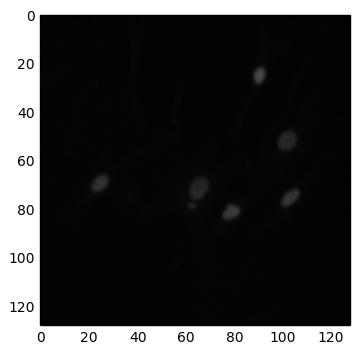

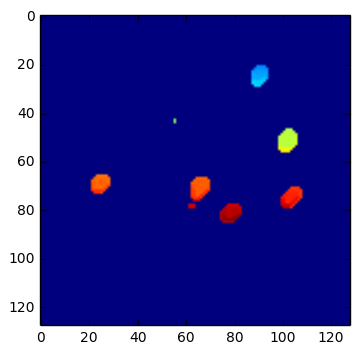

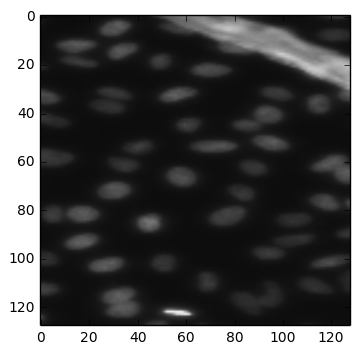

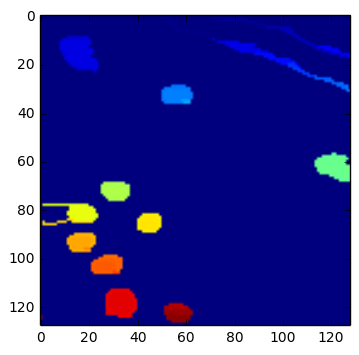

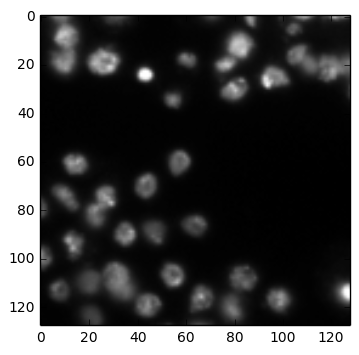

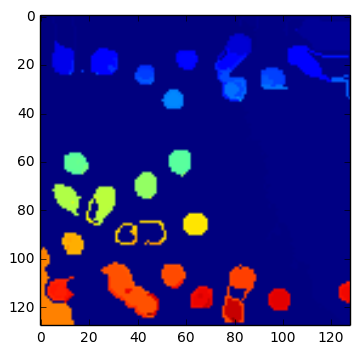

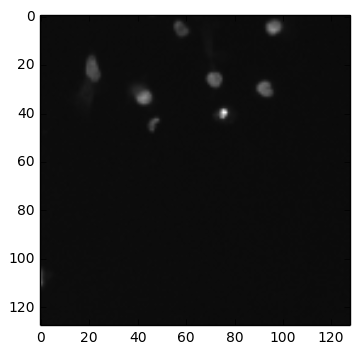

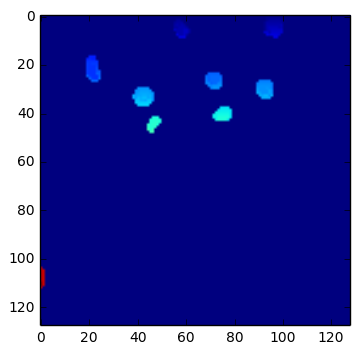

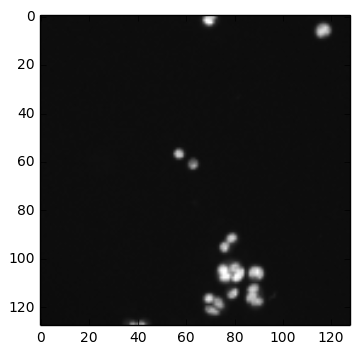

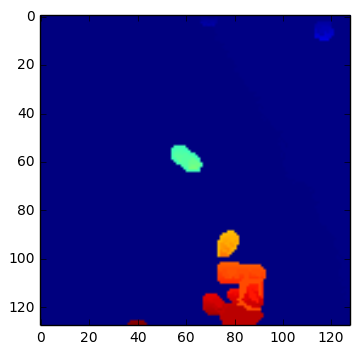

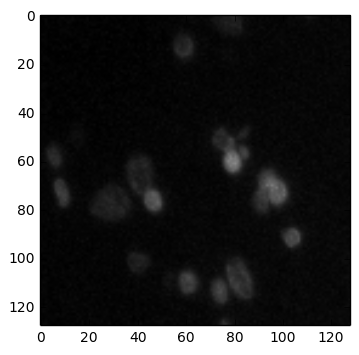

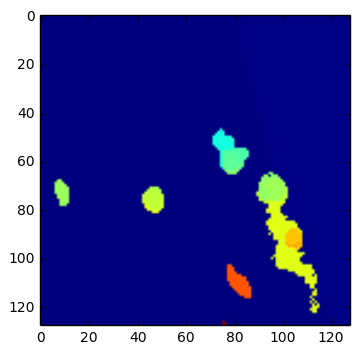

KeyboardInterrupt: 

In [895]:
for im in test_clusters["sparse"]:
    plt.imshow(im, cmap='jet')
    plt.show()
    plt.imshow(graph_predict(basis_map(im)), cmap='jet')
    plt.show()